In [1]:
import ROOT

Welcome to JupyROOT 6.26/02


The file yields.root contains histogams of a discriminating variable (mti) for the data, the signal and several. First objective is to plot it

In [2]:
fileIn = ROOT.TFile("yields.root")
fileIn.ls()

TFile**		yields.root	
 TFile*		yields.root	
  KEY: TH1F	h_data;1	Data
  KEY: TH1F	h_ww;1	ww
  KEY: TH1F	h_top;1	Top
  KEY: TH1F	h_dytt;1	DYTT
  KEY: TH1F	h_vv;1	WZ/ZZ/W#gamma/Z#gamma
  KEY: TH1F	h_signal300;1	Signal 300 GeV
  KEY: TH1F	h_signal400;1	Signal 400 GeV
  KEY: TH1F	h_signal500;1	Signal 500 GeV
  KEY: TH1F	h_signal600;1	Signal 600 GeV
  KEY: TH1F	h_signal700;1	Signal 700 GeV
  KEY: TH1F	h_signal900;1	Signal 900 GeV
  KEY: TH1F	h_signal1000;1	Signal 1000 GeV


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


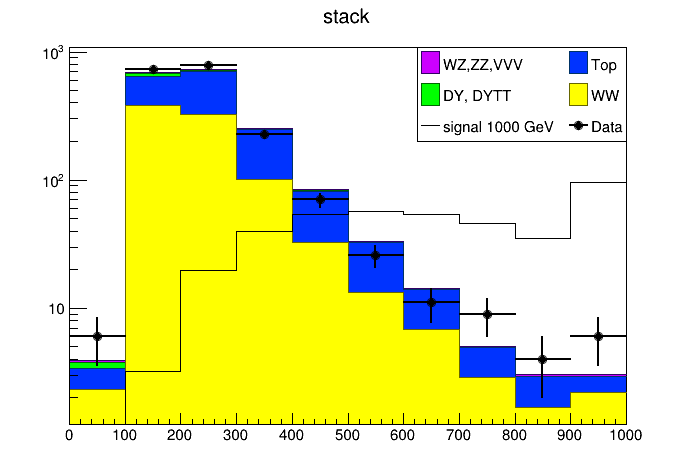

In [3]:
mass="1000"
scaleSignal=100.

h_data   = fileIn.Get("h_data")
h_data.SetLineColor(1)
h_data.SetLineWidth(2)
h_data.SetMarkerColor(1)
h_data.SetMarkerStyle(20)

h_top    = fileIn.Get("h_top")
h_top.SetFillColor(ROOT.kAzure)
h_top.SetLineColor(ROOT.kAzure+3)

h_ww     = fileIn.Get("h_ww")
h_ww.SetFillColor(ROOT.kYellow)
h_ww.SetLineColor(ROOT.kYellow+3)

h_dytt   = fileIn.Get("h_dytt")
h_dytt.SetFillColor(ROOT.kGreen)
h_dytt.SetLineColor(ROOT.kGreen+3)

h_vv     = fileIn.Get("h_vv")
h_vv.SetFillColor(ROOT.kViolet)
h_vv.SetLineColor(ROOT.kViolet+3)

h_signal = fileIn.Get("h_signal"+mass)
h_signal.Scale(scaleSignal)
h_signal.SetLineColor(1)

stack =  ROOT.THStack()
stack.SetNameTitle("stack", "stack")
stack.Add(h_ww, "hist")
stack.Add(h_top, "hist")
stack.Add(h_dytt, "hist")
stack.Add(h_vv, "hist")

leg = ROOT.TLegend(0.6, 0.7, 0.9, 0.9)
leg.SetFillColor(0)
leg.SetNColumns(2)
leg.AddEntry(h_vv, "WZ,ZZ,VVV", "f")
leg.AddEntry(h_top, "Top", "f")
leg.AddEntry(h_dytt, "DY, DYTT", "f")
leg.AddEntry(h_ww, "WW", "f")
leg.AddEntry(h_signal, "signal "+mass+" GeV", "l")
leg.AddEntry(h_data, "Data", "lp")


stack.Draw()
h_signal.Draw("HISTsame")
h_data.Draw("same")
leg.Draw("same")

ROOT.gPad.SetLogy()

ROOT.gPad.Draw()

The ```HWWWorkspace``` module defines a function ```getWorkspace``` that is responsible to create a model to fit the data as the sum of the background plus the signal with a chosen mass hypothesis. Differently from other fits that we have encountered in the course, the pdfs for the signal and background do not have an analytical formulation. For this reason we use normalized histograms derived from the simulation as PDFs.
We have four background sources, listed below with their PDF in the code:
   * non resonant WW (```pdf_ww```)
   * backgrounds involving a top wuark (```pdf_top```)
   * backgrounds involving a Z boson decaying to a pair of tau leptons (```pdf_dytt```)
   * bacgrounds involving other diboson processes (WZ,ZZ) (```pdf_vv```)
   
Then we have the signal (```pdf_s```), that comes in different forms depending on the signal mass hypothesis.

We want to fit the amount of signal, and include in the model the fact that our knowledge of the background normalization is affected by a 10% systematic uncertainty. 

To this end, the number of events in each bin is modeled as a poissonian with mean $\nu$:

$\nu=\mu\nu_s + \Sigma_{bkg=ww,top,dytt,vv}\mu_{bkg}*\nu_{bkg}$

In this equation $\nu_s$ and $\nu_{bkg} (bkg=ww,top,dytt,vv)$ are the expected number of signal and background events in each bin. $\mu_s$ is the parameter of interest, and is a multiplier on the number of signal events. It is a free parameter of the model. The $\mu_{bkg}$ are similar multipliers for the individual backgrounds. They are not free in the fit, the enter the likelihood with a log-normal prior with 10% width.


In [4]:
from HWWWorkspace import *

In [5]:
# silence roofit
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True)

First let us find the best fit for mu for each signal hypothesis

In [6]:
def doFit(h_data, w):
  x = w.var("x")
  data = ROOT.RooDataHist("data", "data", x, h_data)
  mu = w.var("mu")
  mu.setConstant(False)

  model = w.pdf("constrained_model")
  model.fitTo(data, ROOT.RooFit.PrintEvalErrors(-1), ROOT.RooFit.Minos(True))
  return mu  

In [7]:
for mass in ['300', '400', '500', '600', '700', '900', '1000']:
  h_signal = fileIn.Get("h_signal"+mass)
  w = getWorkspace(h_ww, h_top, h_dytt, h_vv, h_signal, mass)
  mufit = doFit(h_data, w)
  print(mass,mufit)
    

300 RooRealVar::mu = 0.886617 +/- (-0.64904,0.640253)  L(-10 - 10) 

400 RooRealVar::mu = -0.825371 +/- (-0.419403,0.420809)  L(-10 - 10) 

500 RooRealVar::mu = -1.20393 +/- (-0.471025,0.483981)  L(-10 - 10) 

600 RooRealVar::mu = -1.14372 +/- (-0.602608,0.636239)  L(-10 - 10) 

700 RooRealVar::mu = -0.439549 +/- (-0.763519,0.83555)  L(-10 - 10) 

900 RooRealVar::mu = 1.22381 +/- (-1.2425,1.44579)  L(-10 - 10) 

1000 RooRealVar::mu = 0.0200234 +/- (-0.0161865,0.0192871)  L(-10 - 10) 



Now we compute the significance for the different mass hypothesis. Note that this makes sense only for the cases in which we fit a signal above 0

In [8]:
import math
def getSignif(hdata, w):
  q0 = 0
  x = w.var("x")
  data = ROOT.RooDataHist("data", "data", x, hdata)
  mu = w.var("mu")
  mu.setConstant(False)

  model = w.pdf("model")
  constraints = w.set("constraints")

  nll = model.createNLL(data, ROOT.RooFit.ExternalConstraints(constraints) )
  m = ROOT.RooMinuit(nll)
  m.setPrintLevel(-1000)
  m.migrad()
  muhat = mu.getVal()
  profileLogLikelihood = nll.createProfile(mu)
  if (muhat>0) :
    mu.setVal(0)
    q0 = 2*profileLogLikelihood.getVal()
  del nll
  return math.sqrt(q0)

In [9]:
for mass in ['300', '400', '500', '600', '700', '900', '1000']:
  h_signal = fileIn.Get("h_signal"+mass)
  w = getWorkspace(h_ww, h_top, h_dytt, h_vv, h_signal, mass)
  signif = getSignif(h_data, w)
  print(mass,signif)

300 1.3635382260031188
400 0.0
500 0.0
600 0.0
700 0.0
900 0.9835579756030397
1000 1.270279802229995


Let us compute the observed upper limit qith qs_tilde

In [10]:
def getLimit(h_data, w):
  limit = -1
  x = w.var("x")
  data = ROOT.RooDataHist("data", "data", x, h_data)
  mu = w.var("mu")
  mu.setConstant(False)

  model = w.pdf("model")
  constraints = w.set("constraints")

  nll = model.createNLL(data, ROOT.RooFit.ExternalConstraints(constraints) )
  m = ROOT.RooMinuit(nll)
  m.setPrintLevel(-1000) #silence minuit
  m.migrad() #minimize
  m.hesse()  #hesse
  muhat = mu.getVal()
  muerr = mu.getError()
  
  if (mu.getVal() < 0): #if best fit is negative
    #redo the fit freezing mu to 0
    mu.setVal(0)
    mu.setConstant(True)
    m.migrad()

  minNLL = nll.getVal(); #value of the negative log likelihood at global minimum

  for k in range(1, 5000):
    thismu = k*0.01
    mu.setVal(thismu)  #set mu to a given value
    mu.setConstant(True) # make it constant, so the fit does not touch it
    m.migrad() # minimize
    minNLLmu = nll.getVal() # net the minimum of NLL for that choice of mu
    q_mu = 2*(minNLLmu - minNLL) # compute q_mu
    CLsb = 1;
    #print (muerr)
    # protect in case of numerical precision issues
    if (q_mu<1e-3):
      q_mu=0
    # we use the cumulative PDF of qs_tilde based on https://link.springer.com/article/10.1140/epjc/s10052-011-1554-0
    if (q_mu <= thismu*thismu/muerr/muerr):
      CLsb = 1. - (2*ROOT.Math.normal_cdf(math.sqrt(q_mu))-1.)
    else:
      CLsb = 1. - (ROOT.Math.normal_cdf(math.sqrt(q_mu))+ROOT.Math.normal_cdf((q_mu+thismu*thismu/muerr/muerr)/(2*(thismu/muerr)))-1.)
    if (CLsb < 0.05):
       limit = thismu
       break

  del nll
  del data
  del m  
  return limit


In [11]:
for mass in ['300', '400', '500', '600', '700', '900', '1000']:
  h_signal = fileIn.Get("h_signal"+mass)
  w = getWorkspace(h_ww, h_top, h_dytt, h_vv, h_signal, mass)
  observed_limit = getLimit(h_data, w)
  print(mass,observed_limit)

300 2.14
400 0.28
500 0.27
600 0.51
700 1.33
900 4.25
1000 0.07


Now also get the expected limit, i.e. the limit you would set if you observed exactly the background you expect

In [12]:
h_bkg = h_top.Clone()
h_bkg.Add(h_ww)
h_bkg.Add(h_dytt)
h_bkg.Add(h_vv)

for mass in ['300', '400', '500', '600', '700', '900', '1000']:
  h_signal = fileIn.Get("h_signal"+mass)
  w = getWorkspace(h_ww, h_top, h_dytt, h_vv, h_signal, mass)
  observed_limit = getLimit(h_data, w)
  expected_limit = getLimit(h_bkg, w)
  print(mass,expected_limit, observed_limit)

300 1.35 2.14
400 0.85 0.28
500 1.04 0.27
600 1.43 0.51
700 1.96 1.33
900 3.08 4.25
1000 0.04 0.07


If the background only hypothesis is actually true, I would still expect different limits depending on the statistical fluctuations of the data. How do we estimate this?

We generate toy experiments as fluctuations of the expected background and we compute the limit for each of them. This will give us an idea of hoe the expected limit varies in the background only hipothesis. 

We will generate the "Brazilian band" around the expected limit, with the so called "1 $\sigma$" and "2 $\sigma$" bands. The naming is a misnomer: it has nothing to do with significance: the 2 $\sigma$ band is defined by the 2.5% and 97.5% percentiles of the limits computed on the background-only toys. The 1 $\sigma$ is the 34% and 84% percentiles.

In [ ]:
from array import array

masses=['300']
#masses = ['300', '400', '500', '600', '700', '900', '1000']
# some arrays to hold the results and make TGraphs afterwards
expected    = array('d')
expectedUp1 = array('d')
expectedUp2 = array('d')
expectedDo1 = array('d')
expectedDo2 = array('d')
observed    = array('d')

# random number generator used to generate toys
rand = ROOT.TRandom3()

#loop over masses
for mass in masses:
  h_signal = fileIn.Get("h_signal"+mass)
  w = getWorkspace(h_ww, h_top, h_dytt, h_vv, h_signal, mass)
  observed_limit = getLimit(h_data, w)
  expected_limit = getLimit(h_bkg, w)
  expected.append(expected_limit)
  observed.append(observed_limit)
  #now deal with the toys
  #generate 1000 toys in the background only hypothesis and histogram the 1000 limits,
  h_limit = ROOT.TH1F('h_limit', 'h_limit', 5000, 0, 10)  
  #The histgram is just needed to extract the quantiles
  xq = array('d', [0.025, 0.34, 0.5, 0.84, 0.975]) #positions where to compute the quantiles in [0,1]
  yq = array('d', [0, 0, 0, 0, 0]) # the vector to store the quantiles
  for i in range(500):
      if i%100==0:
            print (f"generating toy {i} for mass {mass}")
      h_toy = h_bkg.Clone() #just to clone the binning etc. It will be refilled
      h_toy.Reset("ICESM")
      h_toy.FillRandom(h_bkg, rand.Poisson(h_bkg.Integral()), rand)
      toy_limit = getLimit(h_toy, w)
      del h_toy
      h_limit.Fill(toy_limit)
  h_limit.GetQuantiles(5,yq,xq)
  #h_limit.Draw()
  #ROOT.gPad.Draw()
  print (f'mass {mass} --> \
         expected limit {expected_limit}, \
         2 sigma down {yq[0]}, \
         1 sigma down {yq[1]}, \
         1 sigma up {yq[3]}, \
         2 sigma up {yq[4]}, \
         observed {observed_limit}')
  expectedUp1.append(yq[3])
  expectedUp2.append(yq[4])
  expectedDo1.append(yq[1])
  expectedDo2.append(yq[0])   
    

generating toy 0 for mass 300
generating toy 100 for mass 300
generating toy 200 for mass 300
